<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/04_C%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучение модели классификации с использованием сверточной сети ResNet на данных Imagenette

---

В данной работе было реализовано три модели:


- RezNet34
  
  Accuracy на тестовых данных - 0.872
  
  На inference узнала трубу(French horn), вероятность: 1.00


- Упрощенная версия RezNet34 (мне захотелось проверить как будет работать модель с меньшим количеством параметров)
  
  Accuracy на тестовых данных - 0.826

  На inference узнала церковь (church, church building), вероятность: 0.96

  
- RezNet50
  
  Accuracy на тестовых данных - 0.774

  На inference узнала парашют (parachute, chute), вероятность: 1.00


# Imports

In [ ]:
import os
import json
import random
import requests
import tarfile
from PIL import Image
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import torchvision as tv
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

from tqdm.notebook import tqdm
from collections import Counter
from IPython.display import clear_output

# Загрузка и подготовка датасета

In [ ]:
!wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz

!tar -xzf imagenette-320.tgz

!wget -q https://raw.githubusercontent.com/ozendelait/wordnet-to-json/master/mapping_imagenet.json

In [ ]:
# Устанавливаем путь к данным
path = "imagenette-320"

# Создаем преобразования для данных
transform = transforms.Compose([
    transforms.Resize(224),  # Изменяем размер на 224х224
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загружаем данные
dataset = ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Проверяем, что данные загружены корректно
for images, labels in dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
dataset.classes

['train', 'val']

In [ ]:
# Разделение данных
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')

train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Просмотр данных

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

12894
500


In [ ]:
train_dataset.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [ ]:
# Загружаю маппинг из JSON файла
with open('mapping_imagenet.json', 'r') as f:
    class_map = json.load(f)

# Список словарей в форматe: {идентификатор: название}
class_map_dict = {item['v3p0']: item['label'] for item in class_map}

# Словарь для удобства {индекс класса: название класса}
index_to_class = {value: key for key, value in train_dataset.class_to_idx.items()}

# Словарь с названиями классов на основе index_to_class
index_to_class_name = {index: class_map_dict[cls] for index, cls in index_to_class.items()}

# Объединяю словари index_to_class и index_to_class_name
combined_labels = {index:(cls, index_to_class_name[index]) for index, cls in index_to_class.items()}

for index, (cls, human_name) in combined_labels.items():
    print(f"{index}: {cls}, {human_name}")

0: n01440764, tench, Tinca tinca'
1: n02102040, English springer, English springer spaniel'
2: n02979186, cassette player'
3: n03000684, chain saw, chainsaw'
4: n03028079, church, church building'
5: n03394916, French horn, horn'
6: n03417042, garbage truck, dustcart'
7: n03425413, gas pump, gasoline pump, petrol pump, island dispenser'
8: n03445777, golf ball'
9: n03888257, parachute, chute'


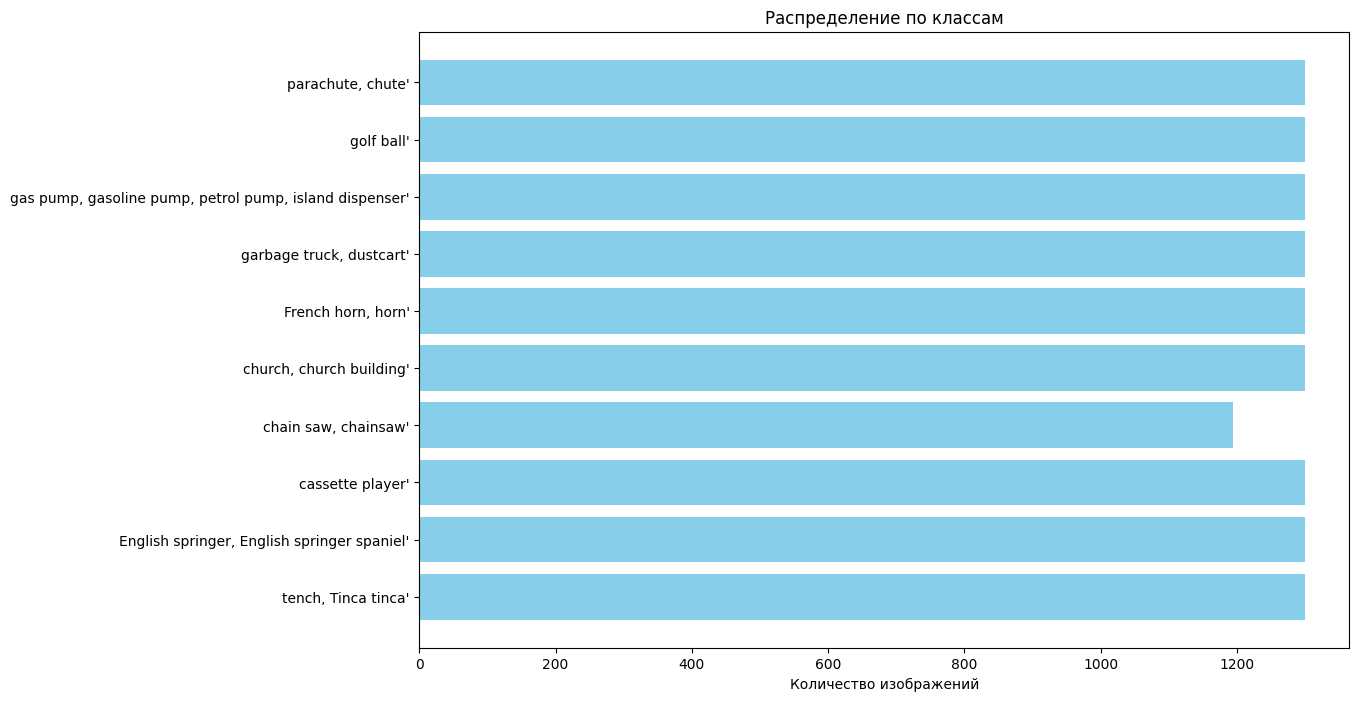

In [ ]:
# Проверка распределения по классам
class_counts = Counter([label for _, label in train_dataset.samples])

class_indices = list(index_to_class_name.keys())
class_labels = [index_to_class_name[idx] for idx in class_indices]
counts = [class_counts[train_dataset.class_to_idx[index_to_class[idx]]] for idx in class_indices]

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 8))
plt.barh(class_labels, counts, color='skyblue')
plt.xlabel('Количество изображений')
plt.title('Распределение по классам')
plt.show()

In [ ]:
# Функция для разнормализации изображения
def denormalize(img, mean, std):
    img = img.clone()  # Клонируем, чтобы не изменять оригинал
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Разнормализация
    return img

# Средние и стандартные отклонения, используемые при нормализации
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

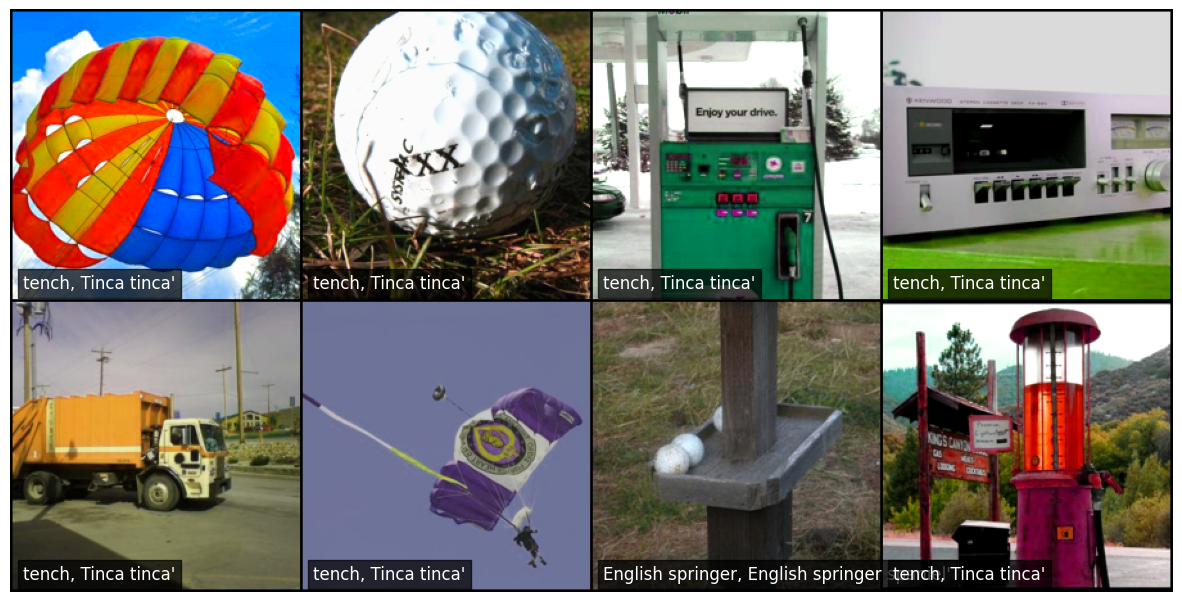

In [ ]:
# Выбираем случайные 8 индексов изображений
random_indices = random.sample(range(len(dataset)), 8)
images = [denormalize(dataset[i][0], mean, std) for i in random_indices]
labels = [combined_labels[dataset[i][1]][1] for i in random_indices]  # Используем human_name из combined_labels

# Создаем сетку изображений
grid = make_grid(images, nrow=4, padding=2)

# Отображаем изображения
plt.figure(figsize=(15, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')

# Добавляем названия классов под каждое изображение
for i, label in enumerate(labels):
    row = i // 4
    col = i % 4
    x = col * (grid.shape[2] // 4) + 10
    y = (row + 1) * (grid.shape[1] // 2) - 10
    plt.text(x, y, label, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.7))

plt.show()

In [ ]:
images, indxs = next(iter(train_loader))
print(images.shape)
print(indxs)

torch.Size([32, 3, 224, 224])
tensor([6, 6, 4, 1, 9, 0, 7, 5, 1, 4, 5, 7, 4, 8, 0, 8, 0, 5, 7, 1, 1, 3, 1, 6,
        0, 6, 4, 7, 1, 2, 4, 4])


# RezNet34

In [ ]:
# Модель RezNet
model_res = tv.models.resnet.resnet34()
model_res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Настройка гиперпараметров

In [ ]:
# Инициализация модели и вывод архитектуры
model = ResNet(num_classes=10)
print("ResNet34 architecture")
summary(model, (3, 224, 224), device="cpu")

ResNet34 architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU

In [ ]:
# Оптимизатор и функция ошибки
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Планировщик для изменения скорости обучения
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Инициализация модели и перемещение на девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
# Функция отрисовки метрик
def plot_metrics(metrics):
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# Проверка загрузки данных и работы модели
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)
    break

Train

Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 1.9833
Train Accuracy: 0.3071
Val Loss: 1.5790
Val Accuracy: 0.4560
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 1.5117
Train Accuracy: 0.4841
Val Loss: 1.2608
Val Accuracy: 0.5680
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 1.3007
Train Accuracy: 0.5647
Val Loss: 1.5123
Val Accuracy: 0.5200
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 1.1125
Train Accuracy: 0.6355
Val Loss: 1.0826
Val Accuracy: 0.6460
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 0.9649
Train Accuracy: 0.6895
Val Loss: 0.9335
Val Accuracy: 0.6940
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 0.8723
Train Accuracy: 0.7186
Val Loss: 0.8226
Val Accuracy: 0.7540
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 0.7869
Train Accuracy: 0.7468
Val Loss: 0.6999
Val Accuracy: 0.7780
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 0.7020
Train Accuracy: 0.7702
Val Loss: 0.6767
Val Accuracy: 0.7980
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 0.6398
Train Accuracy: 0.7942
Val Loss: 0.8456
Val Accuracy: 0.7300
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 0.5671
Train Accuracy: 0.8157
Val Loss: 0.7073
Val Accuracy: 0.7740
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 0.4969
Train Accuracy: 0.8345
Val Loss: 0.7754
Val Accuracy: 0.7520
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 0.3096
Train Accuracy: 0.9029
Val Loss: 0.4633
Val Accuracy: 0.8600
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 0.2306
Train Accuracy: 0.9255
Val Loss: 0.4762
Val Accuracy: 0.8520
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 0.1850
Train Accuracy: 0.9403
Val Loss: 0.4912
Val Accuracy: 0.8540
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 0.1629
Train Accuracy: 0.9471
Val Loss: 0.5067
Val Accuracy: 0.8540
LR: 0.000010
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 0.1252
Train Accuracy: 0.9585
Val Loss: 0.5072
Val Accuracy: 0.8560
LR: 0.000010
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 0.1222
Train Accuracy: 0.9622
Val Loss: 0.5184
Val Accuracy: 0.8540
LR: 0.000010
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 0.1177
Train Accuracy: 0.9622
Val Loss: 0.4878
Val Accuracy: 0.8600
LR: 0.000001
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 0.1096
Train Accuracy: 0.9666
Val Loss: 0.5303
Val Accuracy: 0.8680
LR: 0.000001
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 0.1105
Train Accuracy: 0.9662
Val Loss: 0.4925
Val Accuracy: 0.8620
LR: 0.000001
----------------


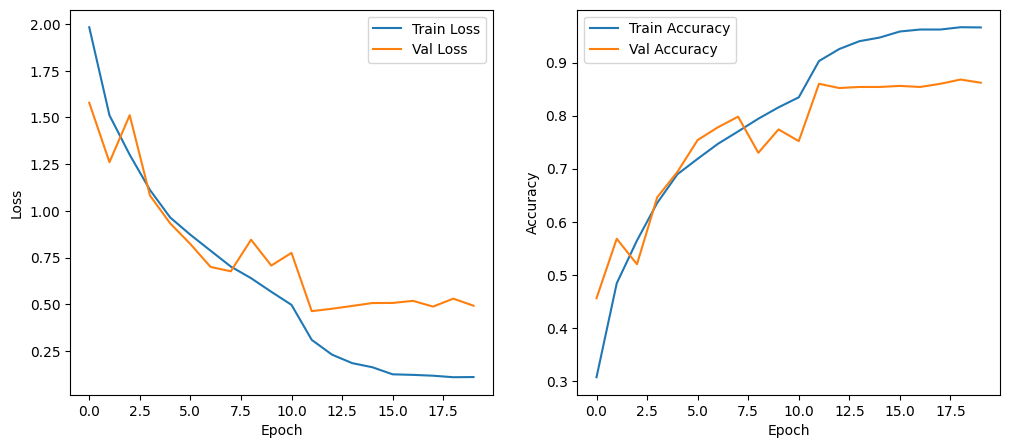

In [ ]:
# Количество эпох обучения и словарь метрик
epochs = 20
metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model.train()
    loss_val = 0
    acc_val = 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

        loss_val += loss.item() * images.size(0)
        acc_val += (pred.argmax(dim=1) == labels).float().sum().item()

    train_loss = loss_val / len(train_loader.dataset)
    train_acc = acc_val / len(train_loader.dataset)

    # Валидация
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += (pred.argmax(dim=1) == labels).float().sum().item()

    val_loss = val_loss / len(test_loader.dataset)
    val_acc = val_acc / len(test_loader.dataset)

    # Обновляем планировщик
    scheduler.step(val_loss)

    # Получаем текущую скорость обучения
    current_lr = optimizer.param_groups[0]['lr']

    # Выводим результаты для текущей эпохи
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f}')
    print(f'LR: {current_lr:.6f}')
    print('----------------')

    # Сохраняем метрики
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)

# Отображаем графики метрик
plot_metrics(metrics)

Сохранение весов

In [ ]:
# сохранить веса модели на диск
model_path = 'model_ResNet34.pt'
torch.save(model.state_dict(), model_path)

Загрузка весов

In [ ]:
# перемещаем модель на девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# загрузка весов с диска
state_dict = torch.load(model_path, map_location=device)

# загрузка весов в модель
model.load_state_dict(state_dict)

<ipython-input-25-77af4a2499c1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


<All keys matched successfully>

Inference

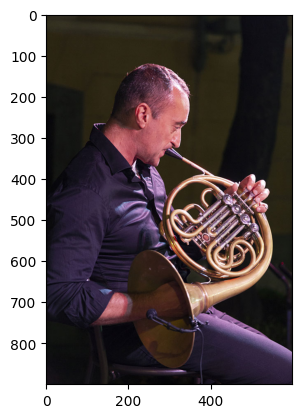

In [ ]:
image_url = 'https://www.wagner-tuba.com/rhapsody/wp-content/uploads/2020/11/hoffer-horn.jpg'
pil_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

plt.imshow(pil_image);

In [ ]:
# Применение преобразований
tensor_image = transform(pil_image)

# Перемещение модели на девайс и переведение в режим инференса
model.eval()
tensor_image = tensor_image.unsqueeze(0).to(device)  # Добавляем размер батча

# Инференс
with torch.no_grad():
    logits = model(tensor_image)

# получить индекс предсказанного класса - максимальный логит
class_index = logits.argmax(dim=-1).item()

# получить вероятности предсказанных классов
probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()

print(f'Предсказанный класс: {index_to_class[class_index]}')
print('--------------------')
for idx, prob in enumerate(probs):
    print(f'Класс: {index_to_class_name[idx]}, вероятность: {prob:.2f}')

Предсказанный класс: n03394916
--------------------
Класс: tench, Tinca tinca', вероятность: 0.00
Класс: English springer, English springer spaniel', вероятность: 0.00
Класс: cassette player', вероятность: 0.00
Класс: chain saw, chainsaw', вероятность: 0.00
Класс: church, church building', вероятность: 0.00
Класс: French horn, horn', вероятность: 1.00
Класс: garbage truck, dustcart', вероятность: 0.00
Класс: gas pump, gasoline pump, petrol pump, island dispenser', вероятность: 0.00
Класс: golf ball', вероятность: 0.00
Класс: parachute, chute', вероятность: 0.00


# Модель Like_RezNet_34

Упрощенная версия, менее глубокая, чем оригинальная

In [ ]:
class BasicBlock_34(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1, stride=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1, stride=1)
        self.norm1 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out += x
        return self.act(out)

In [ ]:
class BottleneckBlock_34(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.conv0 = nn.Conv2d(nc, nc // 4, kernel_size=1, padding=0)
        self.norm0 = nn.BatchNorm2d(nc // 4)
        self.act = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(nc // 4, nc // 4, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc // 4)
        self.conv2 = nn.Conv2d(nc // 4, nc, kernel_size=1, padding=0)
        self.norm2 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out += x
        return self.act(out)

In [ ]:
class ResTruck_34(nn.Module):
    def __init__(self, nc, num_blocks, block_type='classic'):
        super().__init__()
        blocks = []
        for _ in range(num_blocks):
            if block_type == 'classic':
                blocks.append(BasicBlock_34(nc))
            elif block_type == 'bottleneck':
                blocks.append(BottleneckBlock_34(nc))
            else:
                raise NotImplementedError(f'{block_type} is not implemented')
        self.truck = nn.Sequential(*blocks)

    def forward(self, x):
        return self.truck(x)

In [ ]:
class LikeResNet_34(nn.Module):
    def __init__(self, in_nc, nc, out_nc, block_type):
        super().__init__()
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2, padding=3)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResTruck_34(nc, 3, block_type=block_type)
        self.conv1 = nn.Conv2d(nc, 2*nc, kernel_size=3, stride=2, padding=1)
        self.layer2 = ResTruck_34(2*nc, 4, block_type=block_type)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, kernel_size=3, stride=2, padding=1)
        self.layer3 = ResTruck_34(4*nc, 6, block_type=block_type)
        self.conv3 = nn.Conv2d(4*nc, 4*nc, kernel_size=3, stride=2, padding=1)
        self.layer4 = ResTruck_34(4*nc, 3, block_type=block_type)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out

In [ ]:
like_resnet_model = LikeResNet_34(3, 64, 10, block_type='bottleneck')

# Вывод архитектуры модели
print("Like ResNet-34 architecture")
summary(like_resnet_model, (3, 224, 224), device="cpu")

Like ResNet-34 architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 16, 56, 56]           1,040
       BatchNorm2d-6           [-1, 16, 56, 56]              32
              ReLU-7           [-1, 16, 56, 56]               0
            Conv2d-8           [-1, 16, 56, 56]           2,320
       BatchNorm2d-9           [-1, 16, 56, 56]              32
             ReLU-10           [-1, 16, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]           1,088
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
BottleneckB

Настройка гиперпараметров

In [ ]:
# Инициализация модели
model = LikeResNet_34(3, 64, 10, block_type='bottleneck')

# Опитимизатор и функция ошибки
lr=0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Планировщик для изменения скорости обучения
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Инициализация модели и перемещение на девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
# функция отрисовки метрик, принимает словарь метрик
def plot_metrics(metrics):
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# Проверка загрузки данных и работы модели
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)
    break

 Train

Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 1.9963
Train Accuracy: 0.2935
Val Loss: 1.9336
Val Accuracy: 0.4240
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 1.5501
Train Accuracy: 0.4739
Val Loss: 1.5714
Val Accuracy: 0.4480
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 1.3309
Train Accuracy: 0.5544
Val Loss: 1.4292
Val Accuracy: 0.5360
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 1.1671
Train Accuracy: 0.6153
Val Loss: 1.4384
Val Accuracy: 0.5560
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 1.0664
Train Accuracy: 0.6514
Val Loss: 0.9530
Val Accuracy: 0.7160
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 0.9788
Train Accuracy: 0.6803
Val Loss: 1.0994
Val Accuracy: 0.6060
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 0.8916
Train Accuracy: 0.7088
Val Loss: 0.9920
Val Accuracy: 0.7100
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 0.8328
Train Accuracy: 0.7280
Val Loss: 0.9489
Val Accuracy: 0.6900
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 0.7518
Train Accuracy: 0.7590
Val Loss: 1.1573
Val Accuracy: 0.6420
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 0.7108
Train Accuracy: 0.7697
Val Loss: 0.7255
Val Accuracy: 0.7800
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 0.6518
Train Accuracy: 0.7830
Val Loss: 0.6723
Val Accuracy: 0.7920
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 0.6159
Train Accuracy: 0.7997
Val Loss: 0.7780
Val Accuracy: 0.7720
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 0.5534
Train Accuracy: 0.8157
Val Loss: 0.6966
Val Accuracy: 0.8040
LR: 0.001000
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 0.5230
Train Accuracy: 0.8248
Val Loss: 0.7743
Val Accuracy: 0.7480
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 0.3312
Train Accuracy: 0.8947
Val Loss: 0.5368
Val Accuracy: 0.8360
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 0.2712
Train Accuracy: 0.9173
Val Loss: 0.5600
Val Accuracy: 0.8400
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 0.2369
Train Accuracy: 0.9286
Val Loss: 0.5286
Val Accuracy: 0.8380
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 0.2152
Train Accuracy: 0.9362
Val Loss: 0.5430
Val Accuracy: 0.8480
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 0.1917
Train Accuracy: 0.9435
Val Loss: 0.5501
Val Accuracy: 0.8460
LR: 0.000100
----------------


Training:   0%|          | 0/403 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 0.1801
Train Accuracy: 0.9477
Val Loss: 0.6047
Val Accuracy: 0.8260
LR: 0.000010
----------------


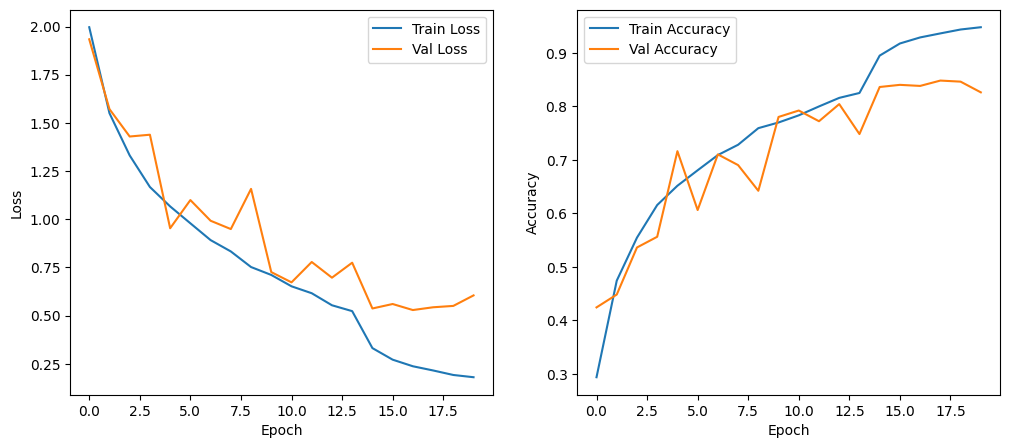

In [ ]:
# Количество эпох обучения и словарь метрик
epochs = 20
metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model.train()
    loss_val = 0
    acc_val = 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

        loss_val += loss.item() * images.size(0)
        acc_val += (pred.argmax(dim=1) == labels).float().sum().item()

    train_loss = loss_val / len(train_loader.dataset)
    train_acc = acc_val / len(train_loader.dataset)

    # Валидация
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred, labels)

            val_loss += loss.item() * images.size(0)
            val_acc += (pred.argmax(dim=1) == labels).float().sum().item()

    val_loss = val_loss / len(test_loader.dataset)
    val_acc = val_acc / len(test_loader.dataset)

    # Обновляем планировщик
    scheduler.step(val_loss)

    # Получаем текущую скорость обучения
    current_lr = optimizer.param_groups[0]['lr']

    # Выводим результаты для текущей эпохи
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f}')
    print(f'LR: {current_lr:.6f}')
    print('----------------')

    # Сохраняем метрики
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)

# Отображаем графики метрик
plot_metrics(metrics)

Сохранение весов

In [ ]:
# сохранить веса модели на диск
model_path = 'model_LikeResNet34.pt'
torch.save(model.state_dict(), model_path)

Загрузка весов

In [ ]:
# перемещаем модель на девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# загрузка весов с диска
state_dict = torch.load(model_path, map_location=device)

# загрузка весов в модель
model.load_state_dict(state_dict)

<ipython-input-40-77af4a2499c1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


<All keys matched successfully>

Inference

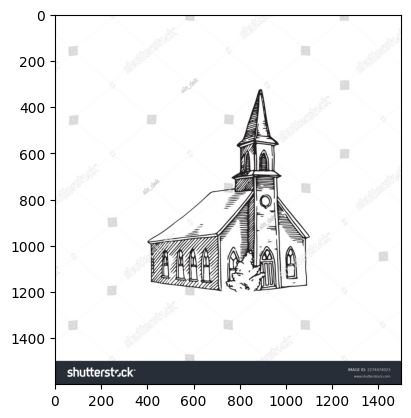

In [ ]:
image_url = 'https://www.shutterstock.com/shutterstock/photos/2274474023/display_1500/stock-vector-church-vector-illustration-in-doodle-sketch-style-2274474023.jpg'
pil_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

plt.imshow(pil_image);

In [ ]:
# Применение преобразований
tensor_image = transform(pil_image)

# Перемещение модели на девайс и переведение в режим инференса
model.eval()
tensor_image = tensor_image.unsqueeze(0).to(device)  # Добавляем размер батча

# Инференс
with torch.no_grad():
    logits = model(tensor_image)

# получить индекс предсказанного класса - максимальный логит
class_index = logits.argmax(dim=-1).item()

# получить вероятности предсказанных классов
probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()

print(f'Предсказанный класс: {index_to_class[class_index]}')
print('--------------------')
for idx, prob in enumerate(probs):
    print(f'Класс: {index_to_class_name[idx]}, вероятность: {prob:.2f}')

Предсказанный класс: n03028079
--------------------
Класс: tench, Tinca tinca', вероятность: 0.00
Класс: English springer, English springer spaniel', вероятность: 0.00
Класс: cassette player', вероятность: 0.00
Класс: chain saw, chainsaw', вероятность: 0.01
Класс: church, church building', вероятность: 0.96
Класс: French horn, horn', вероятность: 0.00
Класс: garbage truck, dustcart', вероятность: 0.00
Класс: gas pump, gasoline pump, petrol pump, island dispenser', вероятность: 0.00
Класс: golf ball', вероятность: 0.01
Класс: parachute, chute', вероятность: 0.02


# ResNet-50

Настройка гиперпараметров

In [ ]:
# Гиперпараметры
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Архитектура
NUM_FEATURES = 28*28
NUM_CLASSES = 10

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRAYSCALE = False

In [ ]:
# Свертка 3х3 с паддингом
def conv3x3(in_nc, out_nc, stride=1):
    return nn.Conv2d(in_nc, out_nc, kernel_size=3, stride=stride, padding=1, bias=False)

In [ ]:
class Bottleneck_50(nn.Module):
    expansion = 4

    def __init__(self, in_nc, nc, stride=1, downsample=None):
        super(Bottleneck_50, self).__init__()
        self.conv1 = nn.Conv2d(in_nc, nc, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(nc)
        self.conv2 = nn.Conv2d(nc, nc, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nc)
        self.conv3 = nn.Conv2d(nc, nc * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(nc * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class ResNet_50(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet_50, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
def resnet_50(num_classes):
    model = ResNet_50(block=Bottleneck_50,
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [ ]:
model_ResNet_50 = resnet_50(NUM_CLASSES)

# Вывод архитектуры модели
print("ResNet_50 architecture")
summary(model_ResNet_50, (3, 224, 224), device="cpu")

ResNet_50 architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2

In [ ]:
# функция отрисовки метрик, принимает словарь метрик
def plot_metrics(metrics):
    epochs_range = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs_range, metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, metrics['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, metrics['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

Train

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = resnet_50(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch: 001/020 | Batch 0000/0403 | Cost: 2.7485
Epoch: 001/020 | Batch 0050/0403 | Cost: 2.0403
Epoch: 001/020 | Batch 0100/0403 | Cost: 2.2650
Epoch: 001/020 | Batch 0150/0403 | Cost: 2.4969
Epoch: 001/020 | Batch 0200/0403 | Cost: 1.6844
Epoch: 001/020 | Batch 0250/0403 | Cost: 1.8384
Epoch: 001/020 | Batch 0300/0403 | Cost: 1.9316
Epoch: 001/020 | Batch 0350/0403 | Cost: 1.7863
Epoch: 001/020 | Batch 0400/0403 | Cost: 1.7475
Epoch 1/20
Train Loss: 1.9692
Train Accuracy: 38.4908
Val Loss: 1.8266
Val Accuracy: 39.2000
LR: 0.000100
----------------
Epoch: 002/020 | Batch 0000/0403 | Cost: 1.7500
Epoch: 002/020 | Batch 0050/0403 | Cost: 1.2314
Epoch: 002/020 | Batch 0100/0403 | Cost: 1.6116
Epoch: 002/020 | Batch 0150/0403 | Cost: 1.4340
Epoch: 002/020 | Batch 0200/0403 | Cost: 1.3538
Epoch: 002/020 | Batch 0250/0403 | Cost: 1.6816
Epoch: 002/020 | Batch 0300/0403 | Cost: 1.3230
Epoch: 002/020 | Batch 0350/0403 | Cost: 1.2629
Epoch: 002/020 | Batch 0400/0403 | Cost: 1.3352
Epoch 2/20
Tr

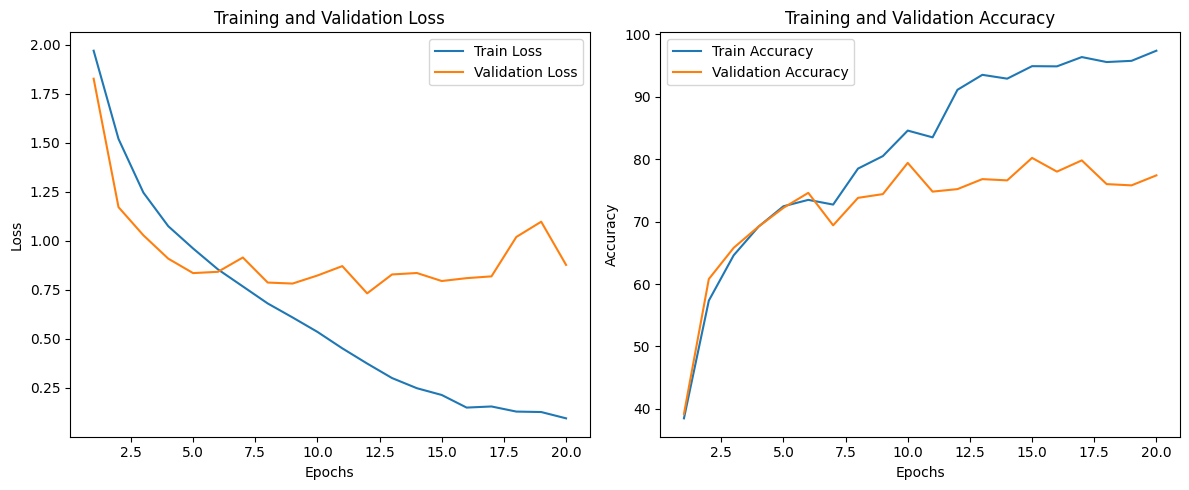

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    with torch.no_grad():  # Отключаем градиенты для вычислений
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):

    model.train()
    running_loss = 0.0

    for batch_idx, (features, targets) in enumerate(train_loader):
        features, targets = features.to(DEVICE), targets.to(DEVICE)

        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        running_loss += cost.item()

        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' %
                  (epoch + 1, NUM_EPOCHS, batch_idx, len(train_loader), cost))

    # После завершения эпохи считаем метрики
    train_loss = running_loss / len(train_loader)
    train_acc = compute_accuracy(model, train_loader, device=DEVICE)
    val_loss = 0.0
    val_acc = compute_accuracy(model, test_loader, device=DEVICE)

    for features, targets in test_loader:
        features, targets = features.to(DEVICE), targets.to(DEVICE)
        logits, _ = model(features)
        cost = F.cross_entropy(logits, targets)
        val_loss += cost.item()

    val_loss /= len(test_loader)

    # Получаем текущую скорость обучения (LR)
    current_lr = optimizer.param_groups[0]['lr']

    # Выводим результаты для текущей эпохи
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print(f'Val Accuracy: {val_acc:.4f}')
    print(f'LR: {current_lr:.6f}')
    print('----------------')

    # Сохраняем метрики
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc.item())
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc.item())

print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

plot_metrics(metrics)

Сохранение весов

In [ ]:
# сохранить веса модели на диск
model_path = 'model_ResNet34.pt'
torch.save(model.state_dict(), model_path)

Загрузка весов

In [ ]:
# перемещаем модель на девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# загрузка весов с диска
state_dict = torch.load(model_path, map_location=device)

# загрузка весов в модель
model.load_state_dict(state_dict)

<ipython-input-23-77af4a2499c1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


<All keys matched successfully>

Inference

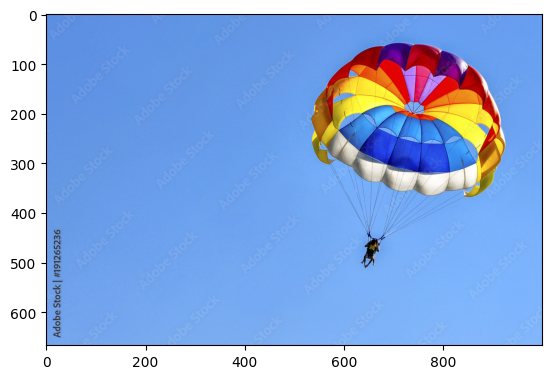

In [ ]:
image_url = 'https://as1.ftcdn.net/v2/jpg/01/91/26/52/1000_F_191265236_JOuRqgmIZEfIpyRlZYw8s41fWxg95deF.jpg'
pil_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

plt.imshow(pil_image);

In [ ]:
# Применение преобразований
tensor_image = transform(pil_image)

# Перемещение модели на девайс и переведение в режим инференса
model.eval()
tensor_image = tensor_image.unsqueeze(0).to(device)  # Добавляем размер батча

# Инференс
with torch.no_grad():
    logits, _ = model(tensor_image)

# получить индекс предсказанного класса - максимальный логит
class_index = logits.argmax(dim=-1).item()

# получить вероятности предсказанных классов
probs = torch.softmax(logits, dim=-1).cpu().numpy().flatten()

print(f'Предсказанный класс: {index_to_class[class_index]}')
print('--------------------')
for idx, prob in enumerate(probs):
    print(f'Класс: {index_to_class_name[idx]}, вероятность: {prob:.2f}')

Предсказанный класс: n03888257
--------------------
Класс: tench, Tinca tinca', вероятность: 0.00
Класс: English springer, English springer spaniel', вероятность: 0.00
Класс: cassette player', вероятность: 0.00
Класс: chain saw, chainsaw', вероятность: 0.00
Класс: church, church building', вероятность: 0.00
Класс: French horn, horn', вероятность: 0.00
Класс: garbage truck, dustcart', вероятность: 0.00
Класс: gas pump, gasoline pump, petrol pump, island dispenser', вероятность: 0.00
Класс: golf ball', вероятность: 0.00
Класс: parachute, chute', вероятность: 1.00
